In [1]:
#import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [3]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [6]:
#visualize the dataset
def imshow(dataloader):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    img = torchvision.utils.make_grid(images)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

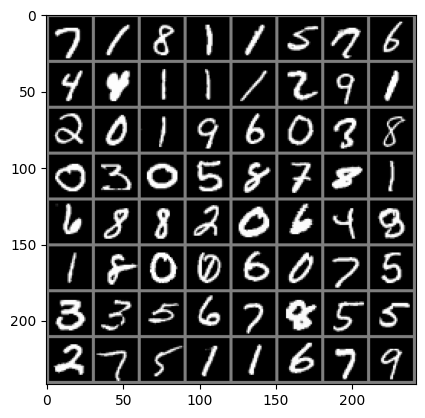

In [7]:
imshow(trainloader)

In [8]:
for images, labels in trainloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [15]:
#LSTM generator
class LSTM_Generator(nn.Module):
    '''
    LSTM takes a random noise and generate synthetic images
    '''
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM_Generator, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.sequential = nn.Sequential(
            nn.Linear(hidden_size, 2048),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.sequential(out[:, -1, :])
        out = out.view(out.size(0), 1, 28, 28)
        return out
        

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
input_size = 28
hidden_size = 128
num_layers = 2
G = LSTM_Generator(input_size, hidden_size, num_layers).to(device)

In [19]:
#feed a random noise to the generator
noise = torch.randn(64, 28, 28).to(device)
fake_images = G(noise)
print(fake_images.shape)

torch.Size([64, 1, 28, 28])


In [21]:
#lstm discriminator
class LSTM_Discriminator(nn.Module):
    '''
    LSTM takes a synthetic image and generate a score
    '''
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM_Discriminator, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.sequential = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.sequential(out[:, -1, :])
        return out

In [22]:
input_size = 28
hidden_size = 64
num_layers = 1
D = LSTM_Discriminator(input_size, hidden_size, num_layers).to(device)

In [23]:
fake_images.shape

torch.Size([64, 1, 28, 28])

In [25]:
#feed the generated image to the discriminator
d_out = D(fake_images.squeeze(1))
print(d_out.shape)

torch.Size([64, 1])


In [26]:
#loss function
criterion = nn.BCELoss()

#optimizer
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))

In [28]:
for images, labels in trainloader:
    images = images.to(device)
    out = D(images.squeeze(1))
    print(out.shape)    
    break

torch.Size([64, 1])


In [32]:
#training
num_epochs = 50
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(trainloader):
        images = images.to(device)
        batch_size = images.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        #train the discriminator
        D_optimizer.zero_grad()
        d_out = D(images.squeeze(1))
        d_loss_real = criterion(d_out, real_labels)
        d_loss_real.backward()
        
        noise = torch.randn(batch_size, 28, 28).to(device)
        fake_images = G(noise)
        d_out = D(fake_images.squeeze(1))
        d_loss_fake = criterion(d_out, fake_labels)
        d_loss_fake.backward()
        D_optimizer.step()
        
        #train the generator
        G_optimizer.zero_grad()
        noise = torch.randn(batch_size, 28, 28).to(device)
        fake_images = G(noise)
        d_out = D(fake_images.squeeze(1))
        g_loss = criterion(d_out, real_labels)
        g_loss.backward()
        G_optimizer.step()
        
        if (i+1) % 300 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(trainloader), d_loss_real+d_loss_fake, g_loss))


Epoch [1/50], Step [300/938], d_loss: 0.4059, g_loss: 1.2579
Epoch [1/50], Step [600/938], d_loss: 0.3888, g_loss: 1.7994
Epoch [1/50], Step [900/938], d_loss: 0.0289, g_loss: 4.4694
Epoch [2/50], Step [300/938], d_loss: 0.0130, g_loss: 5.3501
Epoch [2/50], Step [600/938], d_loss: 0.0081, g_loss: 5.8639
Epoch [2/50], Step [900/938], d_loss: 0.0055, g_loss: 6.2451
Epoch [3/50], Step [300/938], d_loss: 0.0038, g_loss: 6.6261
Epoch [3/50], Step [600/938], d_loss: 0.0029, g_loss: 6.9217
Epoch [3/50], Step [900/938], d_loss: 0.0022, g_loss: 7.1856
Epoch [4/50], Step [300/938], d_loss: 0.0017, g_loss: 7.4577
Epoch [4/50], Step [600/938], d_loss: 0.0013, g_loss: 7.6818
Epoch [4/50], Step [900/938], d_loss: 0.0011, g_loss: 7.8929
Epoch [5/50], Step [300/938], d_loss: 0.0009, g_loss: 8.1186
Epoch [5/50], Step [600/938], d_loss: 0.0007, g_loss: 8.2896
Epoch [5/50], Step [900/938], d_loss: 0.0006, g_loss: 8.4684
Epoch [6/50], Step [300/938], d_loss: 0.0005, g_loss: 8.6617
Epoch [6/50], Step [600/

In [33]:
#gernerate images
noise = torch.randn(64, 28, 28).to(device)
fake_images = G(noise)
fake_images = fake_images.view(-1, 28, 28).cpu().detach().numpy()

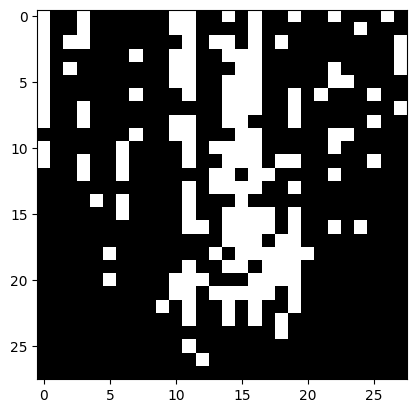

In [34]:
plt.imshow(fake_images[0], cmap='gray')